In [1]:
import pprint

import arviz as az
import corner
import emcee
import george
import matplotlib.pyplot as plt
import numpy as np
import radvel
import scipy.optimize as op
from astropy.table import Table
from george import kernels
from george.gp import LinAlgError
from radvel.plot import mcmc_plots, orbit_plots
import nirps_tools as nirps
import tqdm
import yaml

## Target selection

In [2]:
star = input('Enter star name:')

print('Loading input file and data...')
### System info
working_path = f"stars/{star}/"

# Read input file
try: 
    with open(working_path + 'input.yaml', 'r') as file:
        data = yaml.safe_load(file)
except FileNotFoundError:
    print('This star does not exist in the database.')
    raise


## Loading data

In [ ]:
# Extract data from 'data' dictionary
star_info = data['star']  # Initialize as a list of one empty dictionary if no star data found
instruments = data['instruments']
activity_priors = data['activity_priors']
RV_priors = data['RV_priors']
ccf = data['CCF']
version = 'DRS-3-0-0' # Version of the HARPS pipeline

# Dictionaries to store the LBL data
tbl = {}
t_rv, y_rv, yerr_rv = {}, {}, {}
d2v, sd2v, Dtemp, sDtemp = {}, {}, {}, {}
med_rv_nirps = {}
t_mod = {}
rjd_bjd_off = 2400000.5

# Dictionaries to store the CCF data
tbl_ccf = {}
t_ccf = {}
t_mod_ccf = {}
fwhm = {}
sig_fwhm = {}
y_rv_ccf = {}
yerr_rv_ccf = {}
instruments_ccf = list(tbl_ccf.keys())

hnames = ['gp_amp', 'gp_explength', 'gp_per', 'gp_perlength']

i = 0
for instrument in instruments:
    star_name = star_info.get('name', '')  # Accessing the first element of the star_info list
    ref_star = instruments[instrument].get('ref_star', '')
    suffix = instruments[instrument].get('dtemp_suffix', '')
    bin_label = instruments[instrument].get('bin_label', '')
    pca_label = instruments[instrument].get('pca_label', '')
    
    tbl[instrument] = Table.read(f'stars/{star_name}/data/lbl{bin_label}_{instrument}_{star_name}_{ref_star}{pca_label}_preprocessed.rdb', format='rdb')
    
    # RV data    
    t_rv[instrument], y_rv[instrument], yerr_rv[instrument] = tbl[instrument]['rjd'] , tbl[instrument]['vrad'], tbl[instrument]['svrad']
    t_rv[instrument] += rjd_bjd_off

    # Stellar activity indicators
    d2v[instrument], sd2v[instrument] = tbl[instrument]['d2v']/np.max(tbl[instrument]['d2v']), np.abs(tbl[instrument]['sd2v']/np.max(tbl[instrument]['d2v']))
    d2v[instrument] -= np.median(d2v[instrument])
    Dtemp[instrument], sDtemp[instrument] = tbl[instrument]['DTEMP'+suffix], tbl[instrument]['sDTEMP'+suffix]
    Dtemp[instrument] -= np.median(Dtemp[instrument])

    # Median of the RVs
    med_rv_nirps[instrument] = np.rint(np.median(tbl[instrument]['vrad'].data))
    t_mod[instrument] = np.linspace(np.min(t_rv[instrument]), np.max(t_rv[instrument]), 1000)
    i += 1
    
# # Get the CCF data if it exists
for instrument in instruments_ccf:
    tbl_ccf[instrument] = {}
    if ccf[instrument][version]: 
        # Read the CCF data
        tbl_ccf[instrument][version] = Table.read(f'stars/{star}/data/{star}_{instrument}_DRS-3-0-0.rdb', format='rdb')
        
        # Instances of the data
        t_ccf[instrument] = tbl_ccf[instrument][version]["rjd"] + rjd_bjd_off
        t_mod_ccf[instrument] = np.linspace(np.min(t_ccf[instrument]), np.max(t_ccf[instrument]), 1000)
        fwhm[instrument] = tbl_ccf[instrument][version]['fwhm']
        sig_fwhm[instrument] = tbl_ccf[instrument][version]['sig_fwhm']
        y_rv_ccf[instrument] = tbl_ccf[instrument][version]['vrad']
        yerr_rv_ccf[instrument] = tbl_ccf[instrument][version]['sig_vrad']
    

## Defining prior functions

In [ ]:
print('Computing priors...')

def gaussian_logp(x: float, mu: float, sigma: float) -> float:
    # Copied from radvel for convenience
    return -0.5 * ((x - mu) / sigma) ** 2 - 0.5 * np.log((sigma**2) * 2.0 * np.pi)


def uniform_logp(x: float, minval: float, maxval: float) -> float:
    # Copied from radvel for convenience
    if x <= minval or x >= maxval:
        return -np.inf
    else:
        return -np.log(maxval - minval)


def jeffreys_logp(x: float, minval: float, maxval: float) -> float:
    # Copied from radvel for convenience
    normalization = 1.0 / np.log(maxval / minval)
    if x < minval or x > maxval:
        return -np.inf
    else:
        return np.log(normalization) - np.log(x)


def mod_jeffreys_logp(x: float, minval: float, maxval: float, kneeval: float) -> float:
    normalization = 1.0 / np.log((maxval - kneeval) / (minval - kneeval))
    if (x > maxval) or (x < minval):
        return -np.inf
    else:
        return np.log(normalization) - np.log(x - kneeval)


def log_prior(p: np.ndarray) -> float:
    log_prob = 0.0
    # Mean with wide prior around 0
    if activity_priors['mu']['distribution'] == 'Uniform':
        log_prob += uniform_logp(p[0], activity_priors['mu']['min'], activity_priors['mu']['max'])
    elif activity_priors['mu']['distribution'] == 'loguniform':
        log_prob += jeffreys_logp(p[0], activity_priors['mu']['min'], activity_priors['mu']['max'])
    elif activity_priors['mu']['distribution'] == 'Normal':
        log_prob += gaussian_logp(p[0], activity_priors['mu']['mean'], activity_priors['mu']['std'])
    else:
        raise ValueError(f'Distribution not recognized for mu')
    
    # Log White noise: Uniform
    if activity_priors['noise']['distribution'] == 'Uniform':
        log_prob += uniform_logp(p[1], np.log(activity_priors['noise']['min']**2), np.log(activity_priors['noise']['max']**2))
    elif activity_priors['noise']['distribution'] == 'loguniform':
        log_prob += jeffreys_logp(p[1], np.log(activity_priors['noise']['min']**2), np.log(activity_priors['noise']['max']**2))
    elif activity_priors['noise']['distribution'] == 'Normal':
        log_prob += gaussian_logp(p[1], np.log(activity_priors['noise']['mean']**2), np.log(activity_priors['noise']['std']**2))
    else:
        raise ValueError('Distribution not recognized for white noise')
    
    # Log Variance: Uniform
    if activity_priors['GP_sigma']['distribution'] == 'Uniform':
        log_prob += uniform_logp(p[2], np.log(activity_priors['GP_sigma']['min']**2), np.log(activity_priors['GP_sigma']['max']**2))
    elif activity_priors['GP_sigma']['distribution'] == 'loguniform':
        log_prob += jeffreys_logp(p[2], np.log(activity_priors['GP_sigma']['min']**2), np.log(activity_priors['GP_sigma']['max']**2))
    elif activity_priors['GP_sigma']['distribution'] == 'Normal':
        log_prob += gaussian_logp(p[2], np.log(activity_priors['GP_sigma']['mean']**2), np.log(activity_priors['GP_sigma']['std']**2))
    else: 
        raise ValueError('Distribution not recognized for amplitude')
    
    # Log metric (lambda**2): Uniform
    if activity_priors['GP_length']['distribution'] == 'Uniform':
        log_prob += uniform_logp(p[3], np.log(activity_priors['GP_length']['min']**2), np.log(activity_priors['GP_length']['max']**2))
    elif activity_priors['GP_length']['distribution'] == 'loguniform':
        log_prob += jeffreys_logp(p[3], np.log(activity_priors['GP_length']['min']**2), np.log(activity_priors['GP_length']['max']**2))
    elif activity_priors['GP_length']['distribution'] == 'Normal':
        log_prob += gaussian_logp(p[3], np.log(activity_priors['GP_length']['mean']**2), np.log(activity_priors['GP_length']['std']**2))
    else:
        raise ValueError('Distribution not recognized for length scale')
    
    # Gamma: Jeffreys prior
    if activity_priors['GP_gamma']['distribution'] == 'Uniform':
        log_prob += uniform_logp(p[4], activity_priors['GP_gamma']['min'], activity_priors['GP_gamma']['max'])
    elif activity_priors['GP_gamma']['distribution'] == 'loguniform':
        log_prob += jeffreys_logp(p[4], activity_priors['GP_gamma']['min'], activity_priors['GP_gamma']['max'])
    elif activity_priors['GP_gamma']['distribution'] == 'Normal':
        log_prob += gaussian_logp(p[4], activity_priors['GP_gamma']['mean'], activity_priors['GP_gamma']['std'])
    else:
        raise ValueError('Distribution not recognized for gamma')
    
    # Log Period: Uniform
    if activity_priors['GP_Prot']['distribution'] == 'Uniform':
        log_prob += uniform_logp(p[5], np.log(activity_priors['GP_Prot']['min']), np.log(activity_priors['GP_Prot']['max']))
    elif activity_priors['GP_Prot']['distribution'] == 'loguniform':
        log_prob += jeffreys_logp(p[5], np.log(activity_priors['GP_Prot']['min']), np.log(activity_priors['GP_Prot']['max']))
    elif activity_priors['GP_Prot']['distribution'] == 'Normal':
        log_prob += gaussian_logp(p[5], np.log(activity_priors['GP_Prot']['mean']), np.log(activity_priors['GP_Prot']['std']))
    else:
        raise ValueError('Distribution not recognized for log period')
    
    
    return log_prob

Computing priors...


# Activity indicators

## Choosing the activity indicator

In [ ]:
if activity_priors['chosen_activity'] == 'd2v': 
    print('Activity indicator chosen:', activity_priors['chosen_activity'])
    act, sact = d2v, sd2v

if activity_priors['chosen_activity'] == 'Dtemp': 
    print('Activity indicator chosen:', activity_priors['chosen_activity'])
    act, sact = Dtemp, sDtemp

Activity indicator chosen: d2v


## Creating the GP object

### NIRPS

In [ ]:
# QP-GP hyperparameters
amp = (np.std(act['NIRPS']))
length_scale = activity_priors['GP_length']['guess'] # Length scale
gamma = activity_priors['GP_gamma']['guess'] #Harmonic complexity
log_period = np.log(activity_priors['GP_Prot']['guess']) # Log of the period

# Exponential kernel
ker_sqexp = kernels.ExpSquaredKernel(metric=length_scale**2)  # note the **2 here

#Sinus squared kernel
ker_per = kernels.ExpSine2Kernel(gamma=gamma, log_period=log_period)

# QP-GP kernel
kernel_NIRPS = amp**2 * ker_sqexp * ker_per

gp_NIRPS = {}
mean_val = np.mean(act['NIRPS']) 
log_wn_var = np.log(0.1**2) #white noise variance

gp_NIRPS = george.GP(
    kernel_NIRPS,
    mean=mean_val,
    fit_mean=True,
    white_noise=log_wn_var,
    fit_white_noise=True,
    # fit_white_noise=False,
)



### HARPS

In [ ]:
# QP-GP hyperparameters
amp = np.std(act['HARPS']) # Amplitude of the kernel
length_scale = activity_priors['GP_length']['guess']# Length scale
gamma = activity_priors['GP_gamma']['guess'] #Harmonic complexity
log_period = np.log(activity_priors['GP_Prot']['guess']) # Log of the period

# Exponential kernel
ker_sqexp = kernels.ExpSquaredKernel(metric=length_scale**2)  # note the **2 here

#Sinus squared kernel
ker_per = kernels.ExpSine2Kernel(gamma=gamma, log_period=log_period)

# QP-GP kernel
kernel_HARPS = amp**2 * ker_sqexp * ker_per

gp_HARPS = {}
mean_val = np.mean(act['HARPS']) 
log_wn_var = np.log(0.1**2) #white noise variance

gp_HARPS = george.GP(
    kernel_HARPS,
    mean=mean_val,
    fit_mean=True,
    white_noise=log_wn_var,
    fit_white_noise=True,
    # fit_white_noise=False,
)

## Global parameters vector creator

In [ ]:
def create_combined_params(p_NIRPS, p_HARPS, i_shared):  
    
    comb_params = []
    comb_params_labels = []
    param_names = ['mu', 'log_wn', 'log_amp', 'log_lambda', 'gamma', 'log_Prot']
    
    for i in range(len(p_NIRPS)):
        if i in i_shared:
            comb_params.append(p_NIRPS[i])
            comb_params_labels.append(param_names[i])
        else:
            comb_params.append(p_NIRPS[i])
            comb_params_labels.append(param_names[i] + '_NIRPS')
            comb_params.append(p_HARPS[i])
            comb_params_labels.append(param_names[i] + '_HARPS')
            
    return comb_params, comb_params_labels

def separate_params(comb_params, i_shared):
    p_NIRPS = []
    p_HARPS = []
    
    param_id = 0 # Index of the parameter
    i = 0 # Index of the combined parameters
    while i < len(comb_params):
        if param_id in i_shared:
            p_NIRPS.append(comb_params[i])
            p_HARPS.append(comb_params[i])
        else:
            p_NIRPS.append(comb_params[i])
            p_HARPS.append(comb_params[i+1])
            i += 1
        
        i += 1    
        param_id += 1
            
    return p_NIRPS, p_HARPS


## Defining the posterior function

In [ ]:
# Posterior function
def log_post(p, gp_NIRPS, gp_HARPS, data_NIRPS, data_HARPS, i_shared) -> float:
    
    p_NIRPS, p_HARPS = separate_params(p, i_shared)
    
    log_prob_NIRPS = log_prior(p_NIRPS)
    log_prob_HARPS = log_prior(p_HARPS)
    
    if np.isfinite(log_prob_NIRPS) and np.isfinite(log_prob_HARPS):
        gp_NIRPS.set_parameter_vector(p_NIRPS)
        gp_HARPS.set_parameter_vector(p_HARPS)
        return log_prob_NIRPS + gp_NIRPS.log_likelihood(data_NIRPS, quiet=True) + log_prob_HARPS + gp_HARPS.log_likelihood(data_HARPS, quiet=True)
    return -np.inf

## Combining the shared parameters and computing initial guess

Indices vs. parameters: 

0. `mu` (offset)
1. `log_wn` (jitter noise)
2. `log_amp` (amplitude)
3. `log_lambda` (Coherence length)
4. `gamma` (Number of sub-structures)
5. `log_Prot` (Rotation period)

In [ ]:
################################################
# Parameters to be shared between NIRPS and HARPS
i_indiv = activity_priors['individual_params'] # Indices of the parameters that are instrument-specific
i_shared = activity_priors['shared_params'] # Indices of the parameters that are shared between the instruments
################################################

In [ ]:
p0_NIRPS = gp_NIRPS.get_parameter_vector() #+ 1e-4 * np.random.randn(nwalkers, ndim)
p0_HARPS = gp_HARPS.get_parameter_vector() #+ 1e-4 * np.random.randn(nwalkers, ndim)

gp_NIRPS.compute(t_rv['NIRPS'], yerr=sact['NIRPS'])
gp_HARPS.compute(t_rv['HARPS'], yerr=sact['HARPS'])

gp_NIRPS.set_parameter_vector(p0_NIRPS)
gp_HARPS.set_parameter_vector(p0_HARPS)

p0, labels = create_combined_params(p0_NIRPS, p0_HARPS, i_shared)

## Running `emcee`

Running MCMC fit of the GP hyperparameters...


  0%|          | 8/3100 [00:00<03:38, 14.15it/s]

100%|██████████| 3100/3100 [06:08<00:00,  8.41it/s]


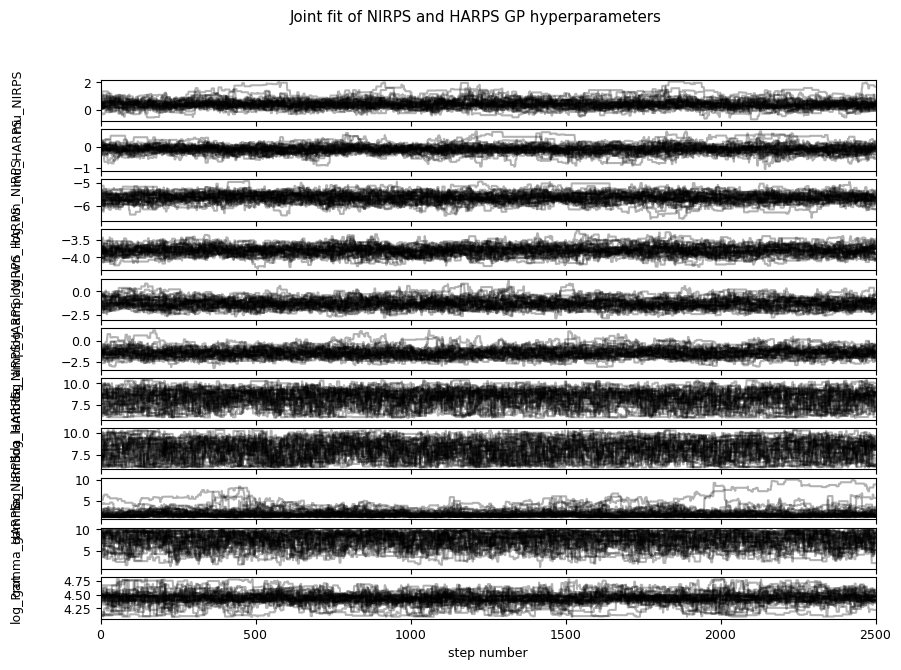

In [ ]:
# MCMC fit of the GP hyperparameters 
print('Running MCMC fit of the GP hyperparameters...')


nwalkers, ndim = 32, len(p0)
num_warmup = 600
num_post_samples = 2500
sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    log_post,
    args=(gp_NIRPS, gp_HARPS, act['NIRPS'], act['HARPS'], i_shared),
    # moves=[emcee.moves.StretchMove()]
    moves=[emcee.moves.DEMove()],
)
# Change the dimension of p0 with the number of walkers
p0 = np.array([p0 + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)])

sampler.run_mcmc(p0, num_post_samples + num_warmup, progress=True)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
post_samples = sampler.get_chain(discard=num_warmup)

for i in range(ndim):
    ax = axes[i]
    ax.plot(post_samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(post_samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
plt.suptitle('Joint fit of NIRPS and HARPS GP hyperparameters')
plt.savefig(f"stars/{star}/joint_fit/act_GP_traceplot.png")

In [ ]:
inf_data = az.from_emcee(sampler, var_names=labels)
inf_data = inf_data.sel(draw=slice(num_warmup, None))

inf_data.to_netcdf(f"stars/{star}/joint_fit/inf_data_act.nc")

# MCMC summary

print(f"Summary for joint fit\n")
print('--------------------------')
print(az.summary(inf_data))

Summary for joint fit

--------------------------


                   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_NIRPS          0.442  0.331  -0.177    1.068      0.013    0.012     887.0   
mu_HARPS         -0.098  0.205  -0.502    0.271      0.007    0.005     898.0   
log_wn_NIRPS     -5.641  0.214  -6.035   -5.249      0.007    0.005     801.0   
log_wn_HARPS     -3.804  0.145  -4.070   -3.525      0.005    0.003    1008.0   
log_amp_NIRPS    -1.279  0.538  -2.283   -0.277      0.023    0.016     546.0   
log_amp_HARPS    -1.424  0.560  -2.428   -0.370      0.022    0.016     631.0   
log_lambda_NIRPS  8.225  1.018   6.020    9.620      0.047    0.033     464.0   
log_lambda_HARPS  8.070  1.140   5.995    9.748      0.045    0.032     671.0   
gamma_NIRPS       1.962  1.076   1.000    3.728      0.077    0.065     432.0   
gamma_HARPS       7.479  1.835   4.147    9.999      0.062    0.044     975.0   
log_Prot          4.434  0.114   4.173    4.654      0.006    0.005     344.0   

                  ess_tail 

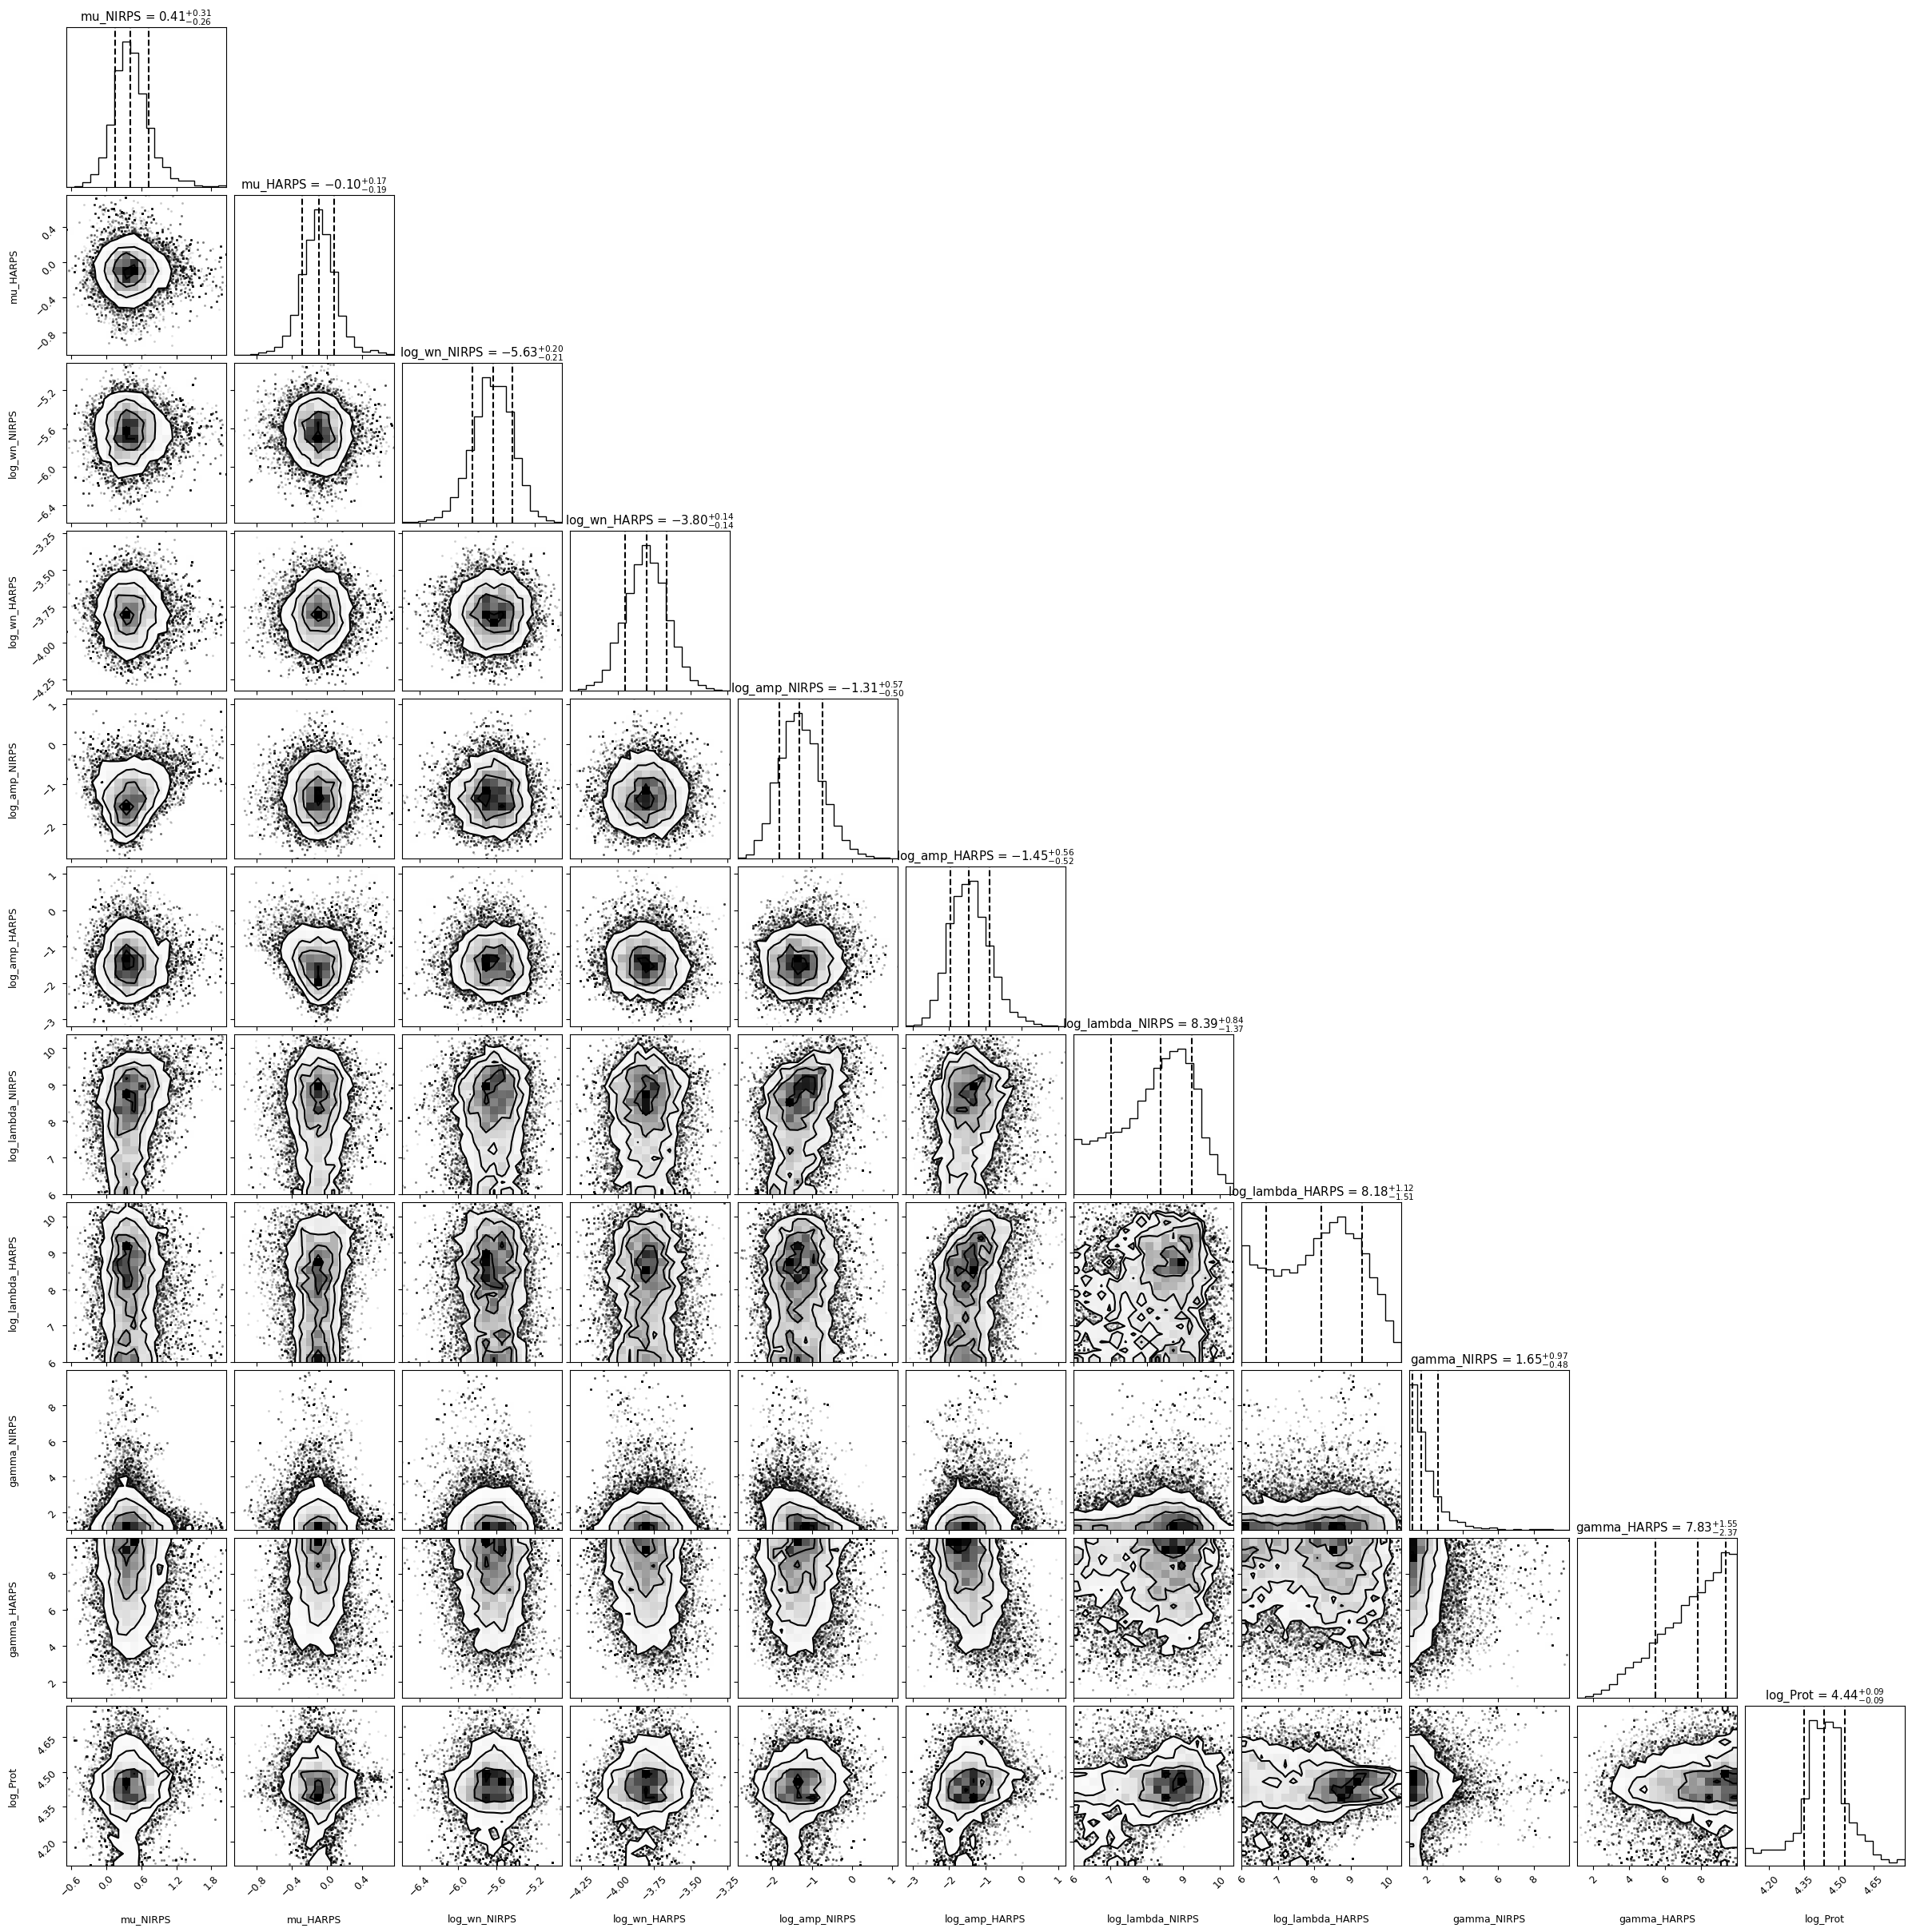

In [ ]:
corner.corner(inf_data, show_titles=True, quantiles=[0.16, 0.5, 0.84])
plt.savefig(f"stars/{star}/joint_fit/act_GP_cornerplot.png")

In [ ]:
max_likelihood_params = inf_data.posterior.max().to_array().values
median_likelihood_params = inf_data.posterior.median().to_array().values

print(f"Median likelihood parameters")
print('--------------------------')
print(median_likelihood_params)

print(f"Maximum likelihood parameters")
print('--------------------------')
print(max_likelihood_params)

Median likelihood parameters
--------------------------
[ 0.41037383 -0.09590853 -5.63437375 -3.80274874 -1.31468287 -1.45061753
  8.39066707  8.18297211  1.65488254  7.82863815  4.43897024]
Maximum likelihood parameters
--------------------------
[ 2.05300669  0.76334793 -4.91354128 -3.23115489  1.14027902  1.20018859
 10.37629467 10.38555268  9.99381314  9.99923933  4.78654768]


Creating posterior samples

In [ ]:
# Visualize posterior samples and max/median likelihood models
print('Creating posterior samples...')

num_display = 50
maxiter = 100
niter = 0
model_post_samples_NIRPS = []
model_post_samples_HARPS = []

while niter < maxiter and len(model_post_samples_NIRPS) < num_display:
    w = np.random.randint(nwalkers)
    n = np.random.randint(num_post_samples)
    
    post_samples_NIRPS, post_samples_HARPS = separate_params(post_samples[n, w], i_shared)
    gp_NIRPS.set_parameter_vector(post_samples_NIRPS)
    gp_HARPS.set_parameter_vector(post_samples_HARPS)
    
    try:
        model_post_samples_NIRPS.append(gp_NIRPS.sample_conditional(act['NIRPS'], t_mod['NIRPS']))
        model_post_samples_HARPS.append(gp_HARPS.sample_conditional(act['HARPS'], t_mod['HARPS']))
    except LinAlgError:
        print("LinAlgError")
        print(f"iteration {niter}")
        print("GP hyperparameters:")
        pprint.pprint(gp_NIRPS.get_parameter_dict())
        pprint.pprint(gp_HARPS.get_parameter_dict())
    niter += 1
    
model_post_samples_NIRPS = np.array(model_post_samples_NIRPS)
model_post_samples_HARPS = np.array(model_post_samples_HARPS)

Creating posterior samples...


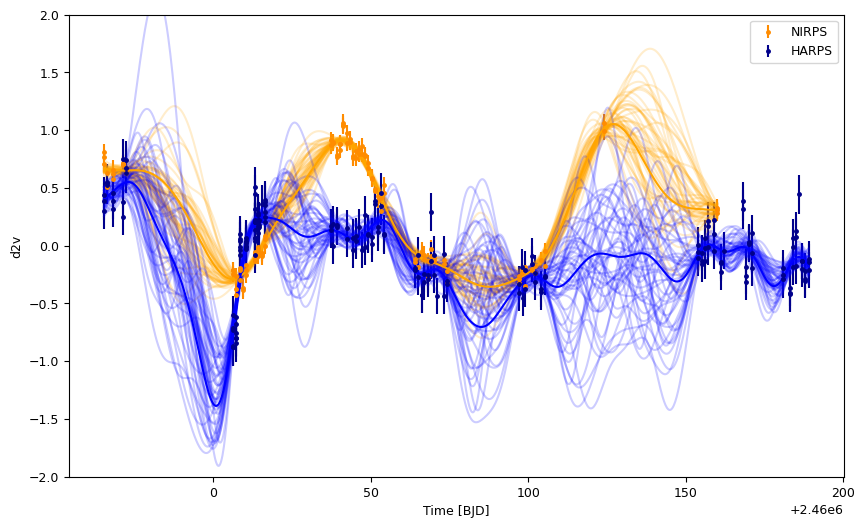

In [ ]:
# Plotting
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True)

# Separate the parameters for each instrument
p_NIRPS_max, p_HARPS_max = separate_params(max_likelihood_params, i_shared)
p_NIRPS_med, p_HARPS_med = separate_params(median_likelihood_params, i_shared)

# NIRPS
## Maximum likelihood parameters
gp_NIRPS.set_parameter_vector(p_NIRPS_max)
mu_max_NIRPS, var_max_NIRPS = gp_NIRPS.predict(act['NIRPS'], t_mod['NIRPS'], return_var=True)
std_max_NIRPS = np.sqrt(var_max_NIRPS)

## Median likelihood parameters
gp_NIRPS.set_parameter_vector(p_NIRPS_med)
mu_med_NIRPS, var_med_NIRPS = gp_NIRPS.predict(act['NIRPS'], t_mod['NIRPS'], return_var=True)
std_med_NIRPS = np.sqrt(var_med_NIRPS)

# HARPS
## Maximum likelihood parameters
gp_HARPS.set_parameter_vector(p_HARPS_max)
mu_max_HARPS, var_max_HARPS = gp_HARPS.predict(act['HARPS'], t_mod['HARPS'], return_var=True)
std_max_HARPS = np.sqrt(var_max_HARPS)

## Median likelihood parameters
gp_HARPS.set_parameter_vector(p_HARPS_med)
mu_med_HARPS, var_med_HARPS = gp_HARPS.predict(act['HARPS'], t_mod['HARPS'], return_var=True)
std_med_HARPS = np.sqrt(var_med_HARPS)

# Plot data
axes.errorbar(t_rv['NIRPS'], act['NIRPS'], yerr=np.sqrt(sact['NIRPS']**2 + np.exp(p_NIRPS_med[1])), color = 'darkorange', fmt=".", label = 'NIRPS')
axes.errorbar(t_rv['HARPS'], act['HARPS'], yerr=np.sqrt(sact['HARPS']**2 + np.exp(p_HARPS_med[1])), color = 'darkblue', fmt=".", label = 'HARPS')

# Plots samples from posterior
axes.plot(t_mod['NIRPS'], model_post_samples_NIRPS.T, color = 'orange', alpha=0.2)
axes.plot(t_mod['HARPS'], model_post_samples_HARPS.T, color = 'blue', alpha=0.2)

# Plot maximum likelihood
# axes.plot(t_mod['NIRPS'], mu_max_NIRPS, color='C0')
# axes.plot(t_mod[instrument], mu_max_HARPS, color='C1')
# axes.fill_between(t_mod['NIRPS'], mu_max_NIRPS - std_max_NIRPS, mu_max_NIRPS + std_max_NIRPS, alpha=0.2)
# axes.fill_between(t_mod['HARPS'], mu_max_HARPS - std_max_HARPS, mu_max_HARPS + std_max_HARPS, alpha=0.2)

# Plot median likelihood
axes.plot(t_mod['NIRPS'], mu_med_NIRPS, color='orange')
axes.plot(t_mod['HARPS'], mu_med_HARPS, color='blue')
# axes.fill_between(t_mod['NIRPS'], mu_med_NIRPS - std_med_NIRPS, mu_med_NIRPS + std_med_NIRPS, alpha=0.2)
# axes.fill_between(t_mod['HARPS'], mu_med_HARPS - std_med_HARPS, mu_med_HARPS + std_med_HARPS, alpha=0.2)

axes.set_ylabel(f"{activity_priors['chosen_activity']}")
axes.set_xlabel(f"Time [BJD]")

if activity_priors['chosen_activity'] == 'Dtemp': plt.ylim(bottom = -50, top = 50)
if activity_priors['chosen_activity'] == 'd2v': plt.ylim(bottom = -2, top = 2)

plt.legend()
plt.savefig(f"stars/{star}/joint_fit/{activity_priors['chosen_activity']}_GP_MC_fit.png")


# Planets + GP analysis

In [ ]:
# Let us start by initializing the parameters
print('Initializing RadVel model...')
instrument = RV_priors['chosen_instrument'] #The instrument we trust the most to lead the GP fit... TODO: Can be changed

# The basis determines the orbit parametrization
params = radvel.Parameters(RV_priors['nplanets'], basis="per tc secosw sesinw k")

# Orbit parameters
params["per1"] = radvel.Parameter(value=RV_priors['per1']['guess'], vary=True)
params["tc1"] = radvel.Parameter(value=RV_priors['tc1']['guess'], vary=True)
params["sesinw1"] = radvel.Parameter(value=RV_priors['sesinw1']['guess'], vary=False)  # fix e = 0 for now
params["secosw1"] = radvel.Parameter(value=RV_priors['secosw1']['guess'], vary=False)
params["k1"] = radvel.Parameter(value=RV_priors['k1']['guess'], vary=True)

if RV_priors['nplanets'] ==2 :
    params["per2"] = radvel.Parameter(value=RV_priors['per2']['guess'], vary=True)
    params["tc2"] = radvel.Parameter(value=RV_priors['tc2']['guess'], vary=True)
    params["sesinw2"] = radvel.Parameter(value=RV_priors['sesinw2']['guess'], vary=False)  # fix e = 0 for now
    params["secosw2"] = radvel.Parameter(value=RV_priors['secosw2']['guess'], vary=False)
    params["k2"] = radvel.Parameter(value=RV_priors['k2']['guess'], vary=True)

Initializing RadVel model...


## Using the activity indicator as a prior

In [ ]:
# Chosen instrument to lead the GP fit of the non-shared parameters
instrument = RV_priors['chosen_instrument'] 
param_names = ['mu', 'log_wn', 'log_amp', 'log_lambda', 'gamma', 'log_Prot']

# Loading potentially shared parameters
inf_post = inf_data.posterior

try: 
    
    inf_post["gp_explength"] = np.sqrt(2*np.exp(inf_post["log_lambda"]))
    params["gp_explength"] = radvel.Parameter(
        value=inf_post.quantile(0.5)["gp_explength"].item())
    
except:
    inf_post['gp_explength_'+instrument] = np.sqrt(2*np.exp(inf_post["log_lambda_"+instrument]))
    params['gp_explength'] = radvel.Parameter(
        value=inf_post.quantile(0.5)["gp_explength_"+instrument].item())

try:     
    inf_post["gp_per"] = np.exp(inf_post["log_Prot"])
    params["gp_per"] = radvel.Parameter(value=inf_post.quantile(0.5)["gp_per"].item())
    
except: 
    inf_post['gp_per_'+instrument] = np.exp(inf_post["log_Prot_"+instrument]) 
    params["gp_per"] = radvel.Parameter(value=inf_post.quantile(0.5)["gp_per_"+instrument].item())
      
    
try:
    inf_post["gp_perlength"] = np.sqrt(0.5 / inf_post["gamma"])
    params["gp_perlength"] = radvel.Parameter(
        value=inf_post.quantile(0.5)["gp_perlength"].item()
    )

except: 
    inf_post['gp_perlength_'+instrument] = np.sqrt(0.5 / inf_post["gamma_"+instrument])
    params["gp_perlength"] = radvel.Parameter(
        value=inf_post.quantile(0.5)["gp_perlength_"+instrument].item()
    )

# Loading individual params
params["gp_amp"] = radvel.Parameter(value=RV_priors['GP_sigma']['guess'], vary=True)


# Creating model
mod = radvel.RVModel(params)
mod.params["dvdt"] = radvel.Parameter(value=0.0, vary=False)
mod.params["curv"] = radvel.Parameter(value=0.0, vary=False)

# Combining the data of both instruments
y_rv_all = np.concatenate([y_rv[instrument] for instrument in instruments])
yerr_rv_all = np.concatenate([yerr_rv[instrument] for instrument in instruments])
t_rv_all = np.concatenate([t_rv[instrument] for instrument in instruments])


like = radvel.likelihood.GPLikelihood(
        mod, t_rv_all, y_rv_all, yerr_rv_all, hnames, kernel_name="QuasiPer"
    )

# Noise and offset
like.params["gamma"] = radvel.Parameter(value=RV_priors['mu']['guess'], vary=True)
like.params["jit"] = radvel.Parameter(value=RV_priors['noise']['guess'], vary=True)


## Creating posterior object and setting priors

In [ ]:
post = radvel.posterior.Posterior(like)

### Planet priors

In [ ]:
# Period of the planet
if RV_priors['per1']['distribution'] == 'Uniform':
    post.priors += [radvel.prior.HardBounds("per1", RV_priors['per1']['min'], RV_priors['per1']['max'])]
elif RV_priors['per1']['distribution'] == 'loguniform':
    post.priors += [radvel.prior.Jeffreys("per1", RV_priors['per1']['min'], RV_priors['per1']['max'])]
elif RV_priors['per1']['distribution'] == 'Normal':
    post.priors += [radvel.prior.Gaussian("per1", RV_priors['per1']['mean'], RV_priors['per1']['std'])]
else: 
    raise ValueError('Distribution not recognized for period of the planet')

# Time of transit
if RV_priors['tc1']['distribution'] == 'Uniform':
    post.priors += [radvel.prior.HardBounds("tc1", RV_priors['tc1']['min'], RV_priors['tc1']['max'])]
elif RV_priors['tc1']['distribution'] == 'loguniform':
    post.priors += [radvel.prior.Jeffreys("tc1", RV_priors['tc1']['min'], RV_priors['tc1']['max'])]
elif RV_priors['tc1']['distribution'] == 'Normal':
    post.priors += [radvel.prior.Gaussian("tc1", RV_priors['tc1']['mean'], RV_priors['tc1']['std'])]
else: 
    raise ValueError('Distribution not recognized for time of transit')

# Semi-amplitude of the planet signal
if RV_priors['k1']['distribution'] == 'Uniform':
    post.priors += [radvel.prior.HardBounds("k1", RV_priors['k1']['min'], RV_priors['k1']['max'])]
elif RV_priors['k1']['distribution'] == 'loguniform':
    post.priors += [radvel.prior.Jeffreys("k1", RV_priors['k1']['min'], RV_priors['k1']['max'])]
elif RV_priors['k1']['distribution'] == 'Normal':
    post.priors += [radvel.prior.Gaussian("k1", RV_priors['k1']['mean'], RV_priors['k1']['std'])]
else:
    raise ValueError('Distribution not recognized for semi-amplitude of the planet signal')

if RV_priors['nplanets'] == 2: 
    # Period of the planet
    if RV_priors['per2']['distribution'] == 'Uniform':
        post.priors += [radvel.prior.HardBounds("per2", RV_priors['per2']['min'], RV_priors['per2']['max'])]
    elif RV_priors['per2']['distribution'] == 'loguniform':
        post.priors += [radvel.prior.Jeffreys("per2", RV_priors['per2']['min'], RV_priors['per2']['max'])]
    elif RV_priors['per2']['distribution'] == 'Normal':
        post.priors += [radvel.prior.Gaussian("per2", RV_priors['per2']['mean'], RV_priors['per2']['std'])]
    elif RV_priors['per2']['distribution'] == 'fixed':
        post.priors += [radvel.prior.Gaussian("per2", RV_priors['per2']['guess'], 1e-10)]
    else: 
        raise ValueError('Distribution not recognized for period of the second planet')

    # Time of transit
    if RV_priors['tc2']['distribution'] == 'Uniform':
        post.priors += [radvel.prior.HardBounds("tc2", RV_priors['tc2']['min'], RV_priors['tc2']['max'])]
    elif RV_priors['tc2']['distribution'] == 'loguniform':
        post.priors += [radvel.prior.Jeffreys("tc2", RV_priors['tc2']['min'], RV_priors['tc2']['max'])]
    elif RV_priors['tc2']['distribution'] == 'Normal':
        post.priors += [radvel.prior.Gaussian("tc2", RV_priors['tc2']['mean'], RV_priors['tc2']['std'])]
    elif RV_priors['tc2']['distribution'] == 'fixed':
        post.priors += [radvel.prior.Gaussian("tc2", RV_priors['tc2']['guess'], 1e-10)]
    else: 
        raise ValueError('Distribution not recognized for the second time of transit')

    # Semi-amplitude of the planet signal
    if RV_priors['k2']['distribution'] == 'Uniform':
        post.priors += [radvel.prior.HardBounds("k2", RV_priors['k2']['min'], RV_priors['k2']['max'])]
    elif RV_priors['k2']['distribution'] == 'loguniform':
        post.priors += [radvel.prior.Jeffreys("k2", RV_priors['k2']['min'], RV_priors['k2']['max'])]
    elif RV_priors['k2']['distribution'] == 'Normal':
        post.priors += [radvel.prior.Gaussian("k2", RV_priors['k2']['mean'], RV_priors['k2']['std'])]
    else:
        raise ValueError('Distribution not recognized for semi-amplitude of the second planet signal')

### GP priors

In [ ]:
# GP parameters
# RV offset
if RV_priors['mu']['distribution'] == 'Uniform':
    post.priors += [radvel.prior.HardBounds("gamma", RV_priors['mu']['min'], RV_priors['mu']['max'])]
elif RV_priors['mu']['distribution'] == 'loguniform':
    post.priors += [radvel.prior.Jeffreys("gamma", RV_priors['mu']['min'], RV_priors['mu']['max'])]
elif RV_priors['mu']['distribution'] == 'Normal':
    post.priors += [radvel.prior.Gaussian("gamma", RV_priors['mu']['mean'], RV_priors['mu']['std'])]
else:
    raise ValueError('Distribution not recognized for sub-structures')

# Amplitude of the GP
if RV_priors['GP_sigma']['distribution'] == 'Uniform':
    post.priors += [radvel.prior.HardBounds("gp_amp", RV_priors['GP_sigma']['min'], RV_priors['GP_sigma']['max'])]
elif RV_priors['GP_sigma']['distribution'] == 'loguniform':
    post.priors += [radvel.prior.Jeffreys("gp_amp", RV_priors['GP_sigma']['min'], RV_priors['GP_sigma']['max'])]
elif RV_priors['GP_sigma']['distribution'] == 'Normal':
    post.priors += [radvel.prior.Gaussian("gp_amp", RV_priors['GP_sigma']['mean'], RV_priors['GP_sigma']['std'])]
elif RV_priors['GP_sigma']['distribution'] == 'fixed':
    post.priors += [radvel.prior.Gaussian("gp_amp", RV_priors['GP_sigma']['guess'], 1e-10)]
else:
    raise ValueError('Distribution not recognized for amplitude of the GP')

# White noise
if RV_priors['noise']['distribution'] == 'Uniform':
    post.priors += [radvel.prior.HardBounds("jit", RV_priors['noise']['min'], RV_priors['noise']['max'])]
elif RV_priors['noise']['distribution'] == 'loguniform':
    post.priors += [radvel.prior.Jeffreys("jit", RV_priors['noise']['min'], RV_priors['noise']['max'])]
elif RV_priors['noise']['distribution'] == 'Normal':
    post.priors += [radvel.prior.Gaussian("jit", RV_priors['noise']['mean'], RV_priors['noise']['std'])]
else:
    raise ValueError('Distribution not recognized for white noise')





# Gaussian around the length scale, period and gamma found from the activity indicator
derived_unc = np.mean(np.abs(inf_post.quantile([0.16, 0.84]) - inf_post.quantile(0.5)))

try: 
    post.priors += [
        radvel.prior.Gaussian(
            "gp_explength",
            inf_post[instrument].quantile(0.5)["gp_explength"].item(),
            derived_unc["gp_explength"],
        )
    ]
    
except: 
    post.priors += [
        radvel.prior.Gaussian(
            "gp_explength",
            inf_post.quantile(0.5)["gp_explength_"+instrument].item(),
            derived_unc["gp_explength_"+instrument],
        )
    ]
    
try: 
    post.priors += [
        radvel.prior.Gaussian(
            "gp_per", inf_post[instrument].quantile(0.5)["gp_per"].item(), derived_unc["gp_per"]
        )
    ]

except:
    post.priors += [
        radvel.prior.Gaussian(
            "gp_per", inf_post[instrument].quantile(0.5)["gp_per_"+instrument].item(), derived_unc["gp_per_"+instrument]
        )
    ]
    
try: 
    post.priors += [
        radvel.prior.Gaussian(
            "gp_perlength",
            inf_post[instrument].quantile(0.5)["gp_perlength"].item(),
            derived_unc["gp_perlength"],
        )
    ]
    
except: 
    post.priors += [
        radvel.prior.Gaussian(
            "gp_perlength",
            inf_post.quantile(0.5)["gp_perlength_"+instrument].item(),
            derived_unc["gp_perlength_"+instrument],
        )
    ]

KeyError: 'NIRPS'

In [ ]:
print(post)

In [ ]:
print("Minimizing negative loglikelihood...")
res = op.minimize(
    post.neglogprob_array,
    post.get_vary_params(),
    method="Powell",
    # options=dict(maxiter=200, maxfev=100000, xatol=1e-8)
)
print('Results:')

print('--------------------------\n')
print(res)

In [ ]:
post.set_vary_params(res.x)
print(post)

In [ ]:
GPPlot = orbit_plots.GPMultipanelPlot(
    post,
    subtract_gp_mean_model=False,
    plot_likelihoods_separately=False,
    subtract_orbit_model=False,
)
GPPlot.plot_multipanel()
plt.show()

GPPlot = orbit_plots.GPMultipanelPlot(
    post,
    subtract_gp_mean_model=False,
    plot_likelihoods_separately=False,
    subtract_orbit_model=True,
)
GPPlot.plot_multipanel()
plt.show()

In [ ]:
print("Running MCMC for 1 planet + GP model...")

chains = radvel.mcmc(
    post, nwalkers=32, nrun=1000, ensembles=4, savename="rawchains.h5"
)

chains.to_csv(f"stars/{star}/joint_fit/1_planet+GP_radvel_chains.csv")

In [ ]:
Corner = mcmc_plots.CornerPlot(post, chains)  # posterior distributions
Corner.plot()
plt.savefig(f"stars/{star}/joint_fit/RV/1_planet+GP_cornerplot.png")